 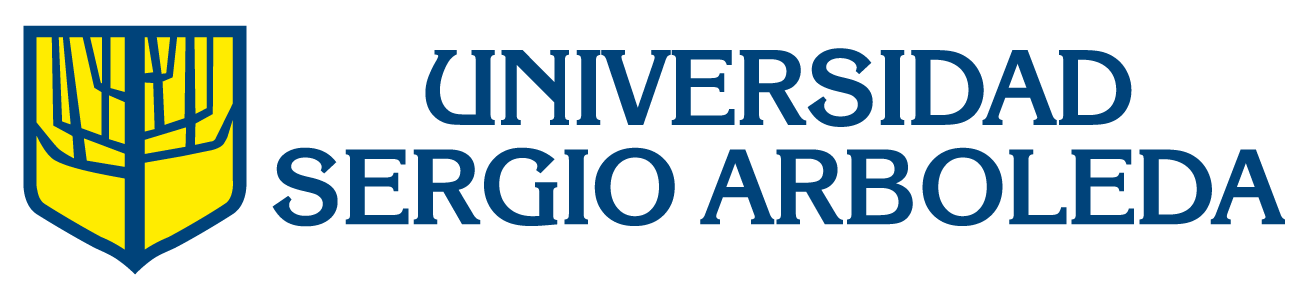
 **Modelos Neuronales** <br> 
**Carrera**:Ingenieria de Sistemas y Telecomunicaciones <br>
**Grupo**:Semillero Software como innovación <br>
**Autor**:Francisco Jose Rivera Gonzalez <br>
**Tutores**: Camilo Enrique Rodriguez Torres <br>

In [ ]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image, ImageEnhance
import tensorflow as tf
from keras.utils import *
from keras.backend import *
from keras.applications.vgg16 import VGG16
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.applications.imagenet_utils import preprocess_input

from tqdm import tqdm
import os
import random

<h1 style="color:#9D00FF; font-family:Sans;">Fuente de datos : [Kaggle Dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)</h1>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dir = '/content/drive/MyDrive/Datos_EMR/Training/'
test_dir = '/content/drive/MyDrive/Datos_EMR/Testing/'

In [ ]:
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

In [ ]:
validation_paths=train_paths[4563:]
validation_labels=train_labels[4563:]

del train_paths[4563:]
del train_labels[4563:]


In [ ]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

<h1 style="color:#9D00FF; font-family:Sans;">Data Augmentation</h1>
<h3 style="font-size:15px; font-family:Sans; line-height: 1.7em;">
    <span style = "color : purple">Random Brightness : </span> 80% - 120%<br>
    <span style = "color : purple">Random Contrast : </span> 80% - 120% <br>
</h3>

In [ ]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

In [ ]:
IMAGE_SIZE = 224

In [ ]:
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

<h1 style="color:#9D00FF; font-family:Sans;">Data Generator</h1>
<p style="font-size:15px; font-family:Sans; line-height: 1.7em">
    Dada una lista de rutas a las imágenes y las etiquetas de su clase, <br>
    esta función aumenta las imágenes, las normaliza, codifica la etiqueta y luego devuelve el lote que el modelo puede usar para entrenar.<br>
</p>

In [ ]:
unique_labels = os.listdir(train_dir)

In [ ]:
def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

In [ ]:
def data_gen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            print
            yield batch_images, batch_labels

<h1 style="color:#9D00FF; font-family:Sans;">Estructura Modelo vvg16</h1>

In [ ]:
#Capas convolucionales
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())


#Capa completamente conectada
model.add(Dropout(0.3))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 250)               6272250   
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1004      
                                                                 
Total params: 20,987,942
Trainable params: 13,352,678
No

In [ ]:
for i in range(len(base_model.layers)):
	
	if 'conv' not in base_model.layers[i].name:
		continue	
	filters, biases = base_model.layers[i].get_weights()
	print("layer number",i,base_model.layers[i].name, filters.shape)

layer number 1 block1_conv1 (3, 3, 3, 64)
layer number 2 block1_conv2 (3, 3, 64, 64)
layer number 4 block2_conv1 (3, 3, 64, 128)
layer number 5 block2_conv2 (3, 3, 128, 128)
layer number 7 block3_conv1 (3, 3, 128, 256)
layer number 8 block3_conv2 (3, 3, 256, 256)
layer number 9 block3_conv3 (3, 3, 256, 256)
layer number 11 block4_conv1 (3, 3, 256, 512)
layer number 12 block4_conv2 (3, 3, 512, 512)
layer number 13 block4_conv3 (3, 3, 512, 512)
layer number 15 block5_conv1 (3, 3, 512, 512)
layer number 16 block5_conv2 (3, 3, 512, 512)
layer number 17 block5_conv3 (3, 3, 512, 512)


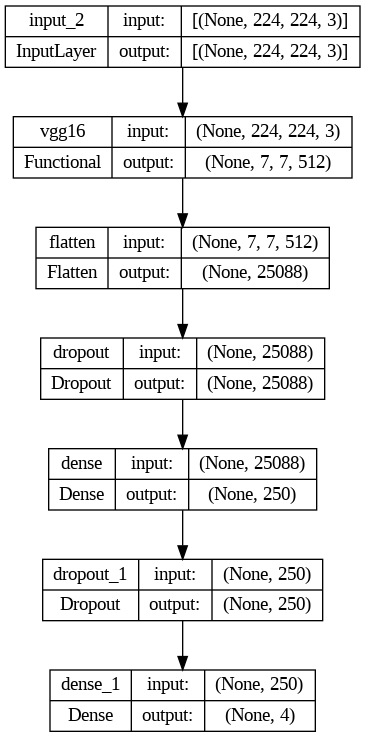

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

<h1 style="color:#9D00FF; font-family:Sans;">Entrenamiento Modelo 1</h1>

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
model2_es = EarlyStopping(monitor = 'val_loss', min_delta = 1e-11, patience = 12, verbose = 1)
model2_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)

# Guardar los mejores pesos del modelo 
model2_mcp = ModelCheckpoint(filepath = 'model1_weights.h5', monitor = 'val_sparse_categorical_accuracy', 
                      save_best_only = True, verbose = 1)

In [ ]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
validation_steps = len(validation_paths)//batch_size
epochs = 100
history = model.fit(data_gen(train_paths, train_labels, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps ,validation_data=data_gen(validation_paths, validation_labels, epochs=epochs),validation_steps=validation_steps , callbacks=[model2_es, model2_rlr, model2_mcp])

Epoch 1/100
228/228 [==============================] - ETA: 0s - loss: 0.4901 - sparse_categorical_accuracy: 0.8154
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.88889, saving model to model1_weights.h5
228/228 [==============================] - 1808s 8s/step - loss: 0.4901 - sparse_categorical_accuracy: 0.8154 - val_loss: 0.3033 - val_sparse_categorical_accuracy: 0.8889 - lr: 1.0000e-04
Epoch 2/100
228/228 [==============================] - ETA: 0s - loss: 0.2799 - sparse_categorical_accuracy: 0.8992
Epoch 2: val_sparse_categorical_accuracy improved from 0.88889 to 0.90015, saving model to model1_weights.h5
228/228 [==============================] - 1213s 5s/step - loss: 0.2799 - sparse_categorical_accuracy: 0.8992 - val_loss: 0.2582 - val_sparse_categorical_accuracy: 0.9001 - lr: 1.0000e-04
Epoch 3/100
228/228 [==============================] - ETA: 0s - loss: 0.1812 - sparse_categorical_accuracy: 0.9342
Epoch 3: val_sparse_categorical_accuracy improved from 0.9001

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'lr'])


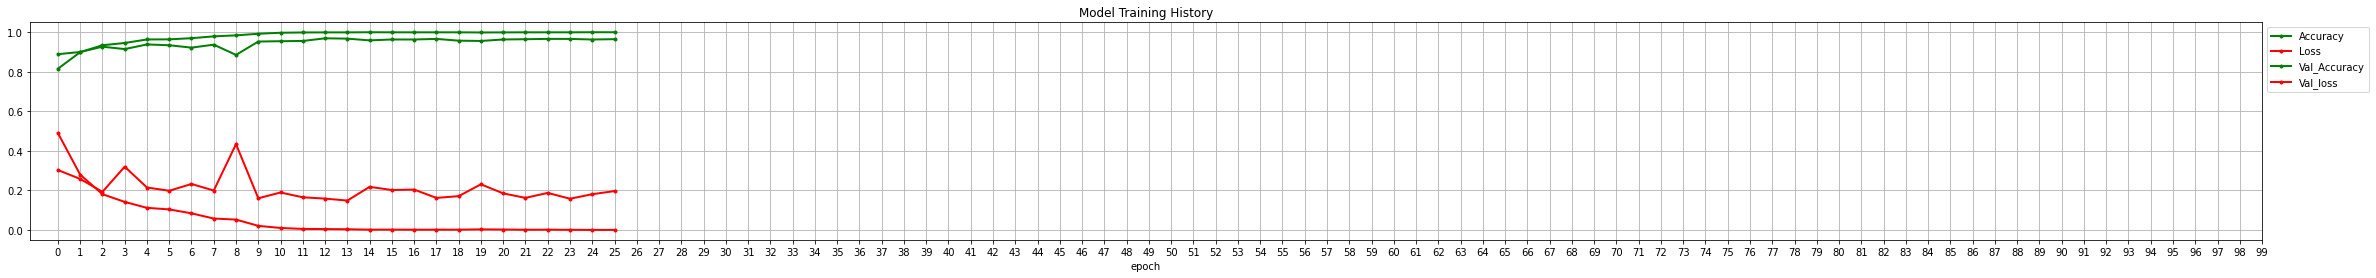

In [ ]:
plt.figure(figsize=(40,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.plot(history.history['val_sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['val_loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss','Val_Accuracy','Val_loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()
#Separar una procion de las imagenes de test para validation

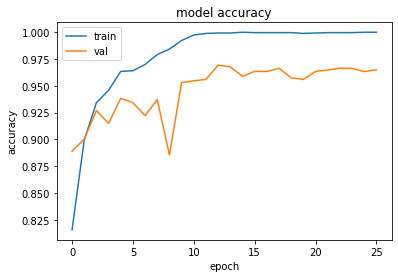

In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

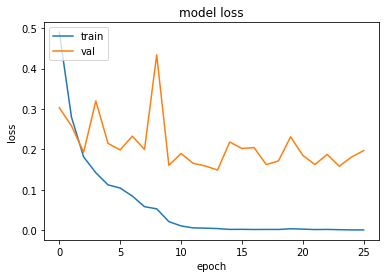

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
image = load_img(test_paths[0] , target_size=(224,224))

# convert the image to an array
image = img_to_array(image)
# expand dimensions so that it represents a single 'sample'
image = expand_dims(image, axis=0)

image = preprocess_input(image)

In [ ]:
for layer in model.layers:
    
    if 'conv' not in layer.name:
        continue    
    filters , bias = layer.get_weights()
    print(layer.name , filters.shape)

In [ ]:
model_to = Model(inputs=base_model.inputs , outputs=base_model.layers[1].output)


1/1 [==============================] - 0s 114ms/step


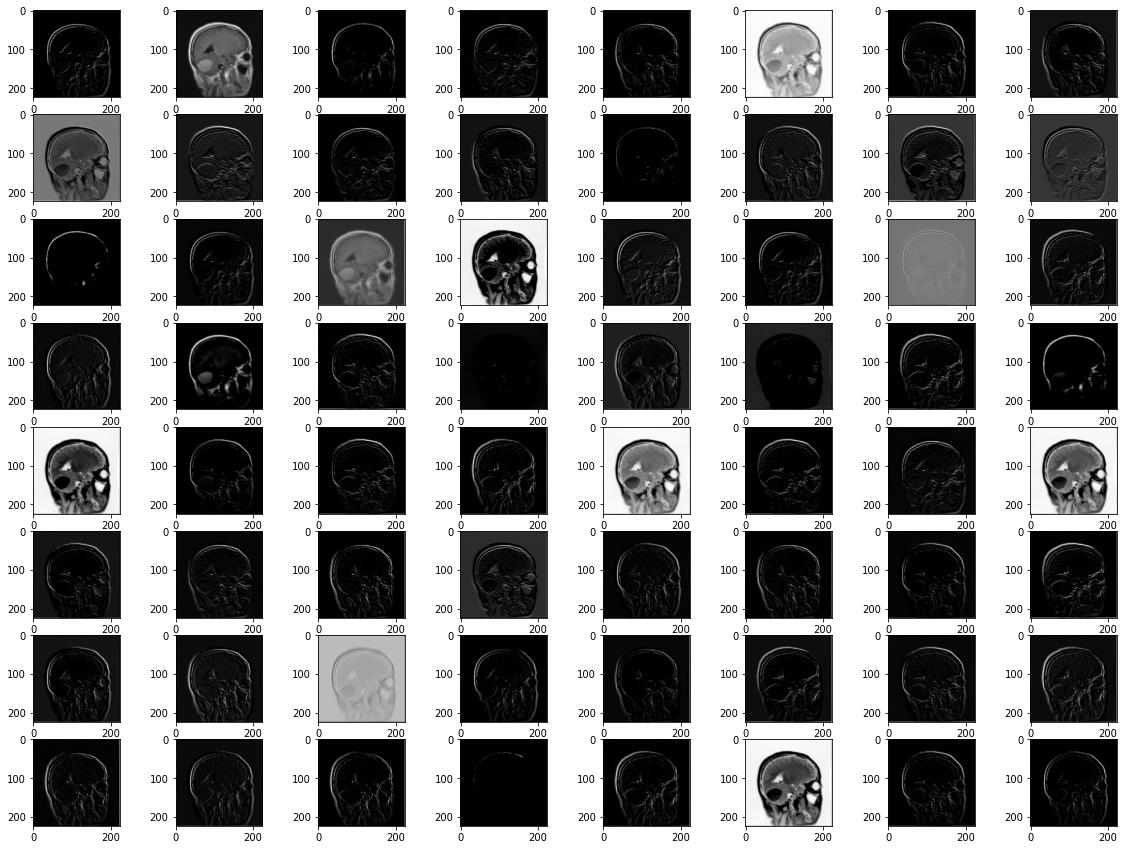

In [ ]:
features = model_to.predict(image)

fig = plt.figure(figsize=(20,15))
for i in range(1,features.shape[3]+1):

     plt.subplot(8,8,i)
     plt.imshow(features[0,:,:,i-1] , cmap='gray')
    
plt.show()

<h1 style="color:#9D00FF; font-family:Sans;">Evaluación Modelo 1

In [ ]:
batch_size=32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(data_gen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
        
    for i in decode_label(y):
        y_true.append(i)
        


In [ ]:
print(classification_report(y_true, y_pred))

In [ ]:
from sklearn.metrics import confusion_matrix


In [ ]:
conffusion_matrix = confusion_matrix(y_true, y_pred )

In [ ]:
print(conffusion_matrix)

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(conffusion_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['glioma', 'meningioma','no tumor','pituitary']); ax.yaxis.set_ticklabels(['glioma', 'meninglioma','no tumor','pituitary']);

<h1 style="color:#9D00FF; font-family:Sans;">Guardar Modelo 1 en formato TFLITE

<h1 style="color:#9D00FF; font-family:Sans;">Modelo InceptionV3:</h1>

In [ ]:
base_model2 = InceptionV3(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
for layer in base_model2.layers:
    layer.trainable = False
for layer in base_model2.layers[249:]:
    layer.trainable = True


In [ ]:
base_model2.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
model2 = Sequential()
model2.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model2.add(base_model2)
model2.add(Flatten())


#Capa completamente conectada
model2.add(Dropout(0.3))
model2.add(Dense(250, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(len(unique_labels), activation='softmax'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dropout_2 (Dropout)         (None, 51200)             0         
                                                                 
 dense_2 (Dense)             (None, 250)               12800250  
                                                                 
 dropout_3 (Dropout)         (None, 250)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1004      
                                                                 
Total params: 34,604,038
Trainable params: 23,916,134


In [ ]:
model2.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [ ]:
model2_es = EarlyStopping(monitor = 'val_loss', min_delta = 1e-11, patience = 12, verbose = 1)
model2_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)

# Guardar los mejores pesos del modelo 
model2_mcp = ModelCheckpoint(filepath = 'model2_weights.h5', monitor = 'val_sparse_categorical_accuracy', 
                      save_best_only = True, verbose = 1)

In [ ]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 100
history = model2.fit(data_gen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps , validation_data=data_gen(validation_paths, validation_labels, epochs=epochs),validation_steps=validation_steps , callbacks=[model2_es, model2_rlr, model2_mcp])

Epoch 1/100
228/228 [==============================] - ETA: 0s - loss: 0.5034 - sparse_categorical_accuracy: 0.8320
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.90936, saving model to model2_weights.h5
228/228 [==============================] - 44s 144ms/step - loss: 0.5034 - sparse_categorical_accuracy: 0.8320 - val_loss: 0.2295 - val_sparse_categorical_accuracy: 0.9094 - lr: 1.0000e-04
Epoch 2/100
228/228 [==============================] - ETA: 0s - loss: 0.0828 - sparse_categorical_accuracy: 0.9703
Epoch 2: val_sparse_categorical_accuracy improved from 0.90936 to 0.93686, saving model to model2_weights.h5
228/228 [==============================] - 31s 135ms/step - loss: 0.0828 - sparse_categorical_accuracy: 0.9703 - val_loss: 0.2253 - val_sparse_categorical_accuracy: 0.9369 - lr: 1.0000e-04
Epoch 3/100
228/228 [==============================] - ETA: 0s - loss: 0.0460 - sparse_categorical_accuracy: 0.9861
Epoch 3: val_sparse_categorical_accuracy improved from 0.93

In [ ]:
plt.figure(figsize=(40,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.plot(history.history['val_sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['val_loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss','Val_Accuracy','Val_loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()
#Separar una procion de las imagenes de test para validation

In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
for layer in model2.layers:
    
    if 'conv' not in layer.name:
        continue    
    filters , bias = layer.get_weights()
    print(layer.name , filters.shape)

In [ ]:
model_to_2 = Model(inputs=model2.inputs , outputs=model2.layers[1].output)

In [ ]:
image = load_img(test_paths[0] , target_size=(224,224))

# convert the image to an array
image = img_to_array(image)
# expand dimensions so that it represents a single 'sample'
image = expand_dims(image, axis=0)

image = preprocess_input(image)

In [ ]:
features_2.shape

In [ ]:
features_2 = model_to_2.predict(image)

fig = plt.figure(figsize=(20,15))
for i in range(1,features_2.shape[1]):

     plt.subplot(8,8,i)
     plt.imshow(features_2[0,:,:,i-1] , cmap='gray')
    
plt.show()

In [ ]:
batch_size=32
steps = int(len(test_paths)/batch_size)
y_pred2 = []
y_true2 = []
for x,y in tqdm(data_gen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred2 = model2.predict(x)
    pred2 = np.argmax(pred2, axis=-1)
    for i in decode_label(pred2):
        y_pred2.append(i)
        
    for i in decode_label(y):
        y_true2.append(i)
        

In [ ]:
print(classification_report(y_true2, y_pred2))

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
conffusion_matrix2 = confusion_matrix(y_true2, y_pred2 )

In [ ]:
print(conffusion_matrix2)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(conffusion_matrix2, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['glioma', 'meningioma','no tumor','pituitary']); ax.yaxis.set_ticklabels(['glioma', 'meninglioma','no tumor','pituitary']);

<h1 style="color:#9D00FF; font-family:Sans;">ResNet50 V2:</h1>

In [ ]:

base_model3 = ResNet50V2(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')

In [ ]:
base_model3.summary()

In [ ]:
for layer in base_model3.layers:
    layer.trainable = False
for layer in base_model3.layers[-20:]:
    layer.trainable = True

In [ ]:
base_model3.summary()

In [ ]:
model3 = Sequential()
model3.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model3.add(base_model3)
model3.add(Flatten())


#Capa completamente conectada
model3.add(Dropout(0.3))
model3.add(Dense(250, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(len(unique_labels), activation='softmax'))

model3.summary()

In [ ]:
model3.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [ ]:
model2_es = EarlyStopping(monitor = 'val_loss', min_delta = 1e-11, patience = 12, verbose = 1)
model2_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)

# Guardar los mejores pesos del modelo 
model2_mcp = ModelCheckpoint(filepath = 'model3_weights.h5', monitor = 'val_sparse_categorical_accuracy', 
                      save_best_only = True, verbose = 1)

In [ ]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 100
history3 = model3.fit(data_gen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps, validation_data=data_gen(validation_paths, validation_labels, epochs=epochs),validation_steps=validation_steps , callbacks=[model2_es, model2_rlr, model2_mcp])

In [ ]:
plt.figure(figsize=(40,4))
plt.grid(True)
plt.plot(history3.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history3.history['loss'], '.r-', linewidth=2)
plt.plot(history3.history['val_sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history3.history['val_loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss','Val_Accuracy','Val_loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()
#Separar una procion de las imagenes de test para validation

In [ ]:
plt.plot(history3.history['sparse_categorical_accuracy'])
plt.plot(history3.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
batch_size=32
steps = int(len(test_paths)/batch_size)
y_pred3 = []
y_true3 = []
for x,y in tqdm(data_gen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred3 = model3.predict(x)
    pred3 = np.argmax(pred3, axis=-1)
    for i in decode_label(pred3):
        y_pred3.append(i)
        
    for i in decode_label(y):
        y_true3.append(i)

In [ ]:
print(classification_report(y_true3, y_pred3))

In [ ]:
for layer in model3.layers:
    
    if 'conv' not in layer.name:
        continue    
    filters , bias = layer.get_weights()
    print(layer.name , filters.shape)

In [ ]:
image = load_img(test_paths[0] , target_size=(224,224))

# convert the image to an array
image = img_to_array(image)
# expand dimensions so that it represents a single 'sample'
image = expand_dims(image, axis=0)

image = preprocess_input(image)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
conffusion_matrix3 = confusion_matrix(y_true3, y_pred3 )

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(conffusion_matrix3, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['glioma', 'meningioma','no tumor','pituitary']); ax.yaxis.set_ticklabels(['glioma', 'meninglioma','no tumor','pituitary']);